In [2]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

In [10]:
harmless_act = torch.load('../data_store/harmless_activations.pt')
harmful_act = torch.load('../data_store/harmful_activations.pt')
intervention_act = torch.load('../data_store/intervention_activations.pt')

layers_to_analyze = [4, 8, 12, 16, 20]
refusal_rate = "10.00%"

In [11]:
def imported_activation_pca(harmless_act, harmful_act, intervention_act, layers, refusal_rate):
    fig, axs = plt.subplots(len(layers) // 2, 2, figsize=(20, 16))
    axs = axs.flatten()

    for idx, layer in enumerate(layers):
        # combine activations & apply PCA
        all_activations = torch.cat([harmless_act, harmful_act, intervention_act], dim=0)
        pca = PCA(n_components=2)
        projected_activations = pca.fit_transform(all_activations.cpu().numpy())

        n = len(harmful_act)
        harmless_proj = projected_activations[:n]
        harmful_proj = projected_activations[n:2*n]
        intervention_proj = projected_activations[2*n:]

        # plot on the corresponding subplot
        axs[idx].scatter(harmless_proj[:, 0], harmless_proj[:, 1], color='green', label='Harmless', alpha=0.6)
        axs[idx].scatter(harmful_proj[:, 0], harmful_proj[:, 1], color='red', label='Harmful', alpha=0.6)
        axs[idx].scatter(intervention_proj[:, 0], intervention_proj[:, 1], color='blue', label='Intervention', alpha=0.6)

        axs[idx].legend()
        axs[idx].set_title(f"PCA of Activations at Layer {layer}")
        axs[idx].set_xlabel("PC 1")
        axs[idx].set_ylabel("PC 2")

    fig.suptitle(f"Refusal Direction PCA\nBase model + LAT adapter\nRefusal Rate: {float(refusal_rate.replace('%', '')):.2%}", fontsize=16)

    plt.tight_layout()
    plt.savefig("refusal_direction_pca_multi_layer.png")
    plt.show()
    plt.close()

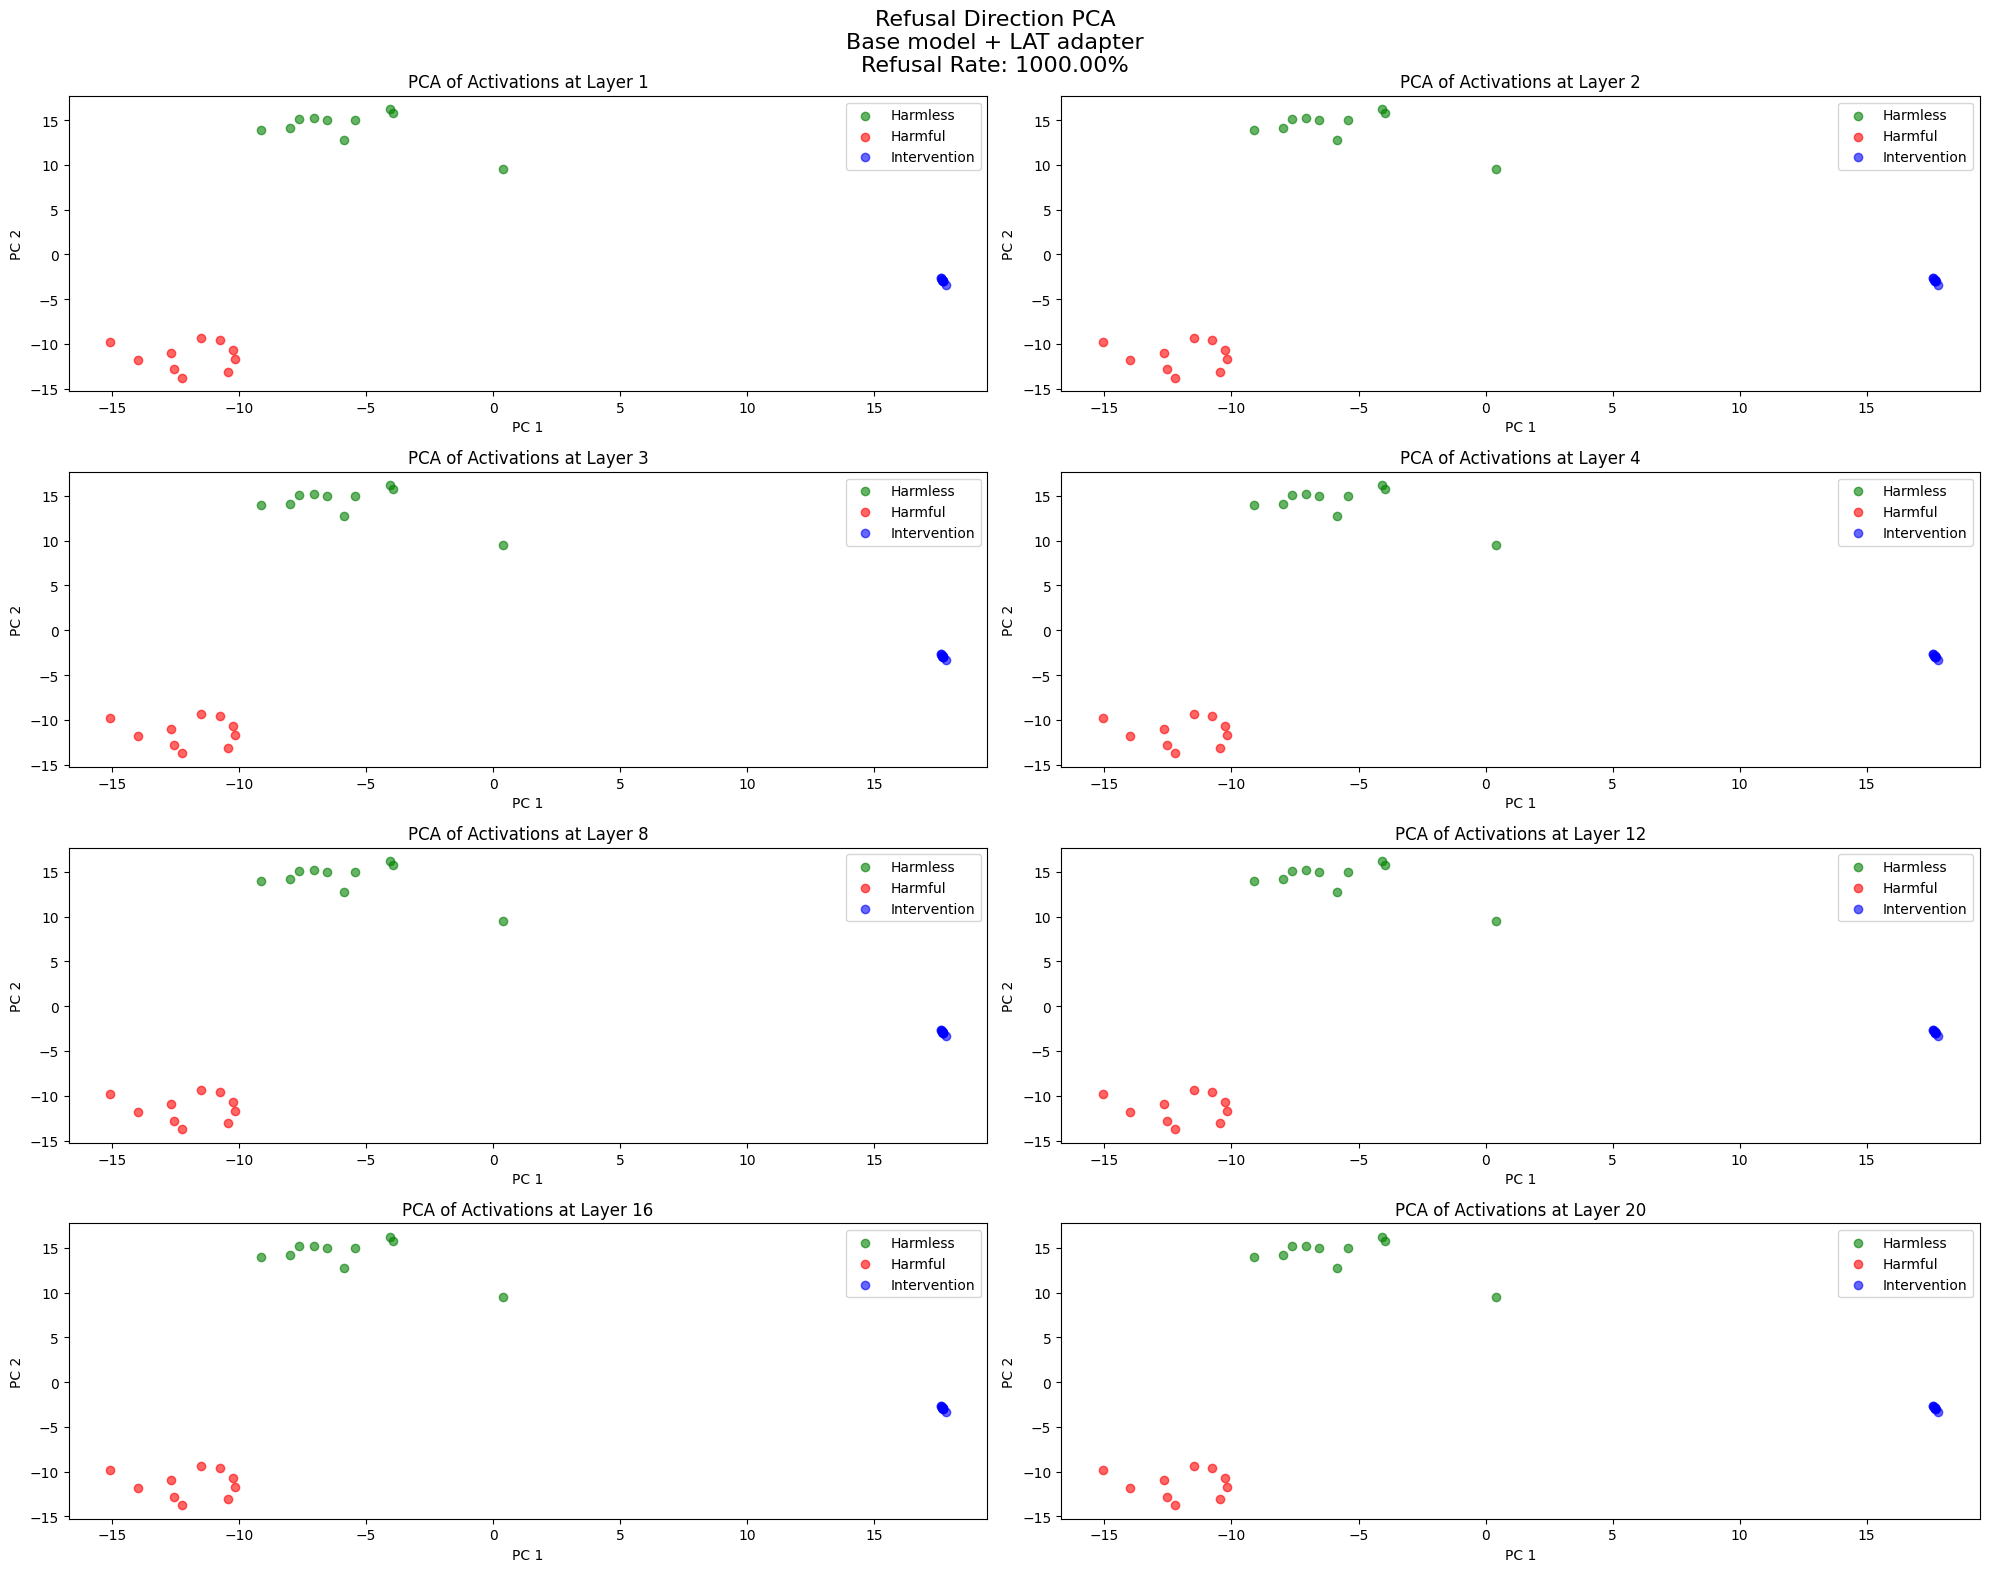

In [12]:
layers_to_analyze = [1, 2, 3, 4, 8, 12, 16, 20]

imported_activation_pca(
    harmless_act,
    harmful_act,
    intervention_act,
    layers_to_analyze,
    refusal_rate
  )